# Coursera IBM Data Science Capstone
Opening a new fast food joint in CABA, Argentina

I will star by importing the libaries that seem necessary for the project

In [2]:
!pip install folium
!pip install geocoder

     |████████████████████████████████| 102kB 6.5MB/s ta 0:00:01
     |████████████████████████████████| 102kB 8.5MB/s ta 0:00:011


In [4]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import json

from geopy.geocoders import Nominatim
import geocoder

import requests
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans

import folium

%matplotlib inline

print('Libraries importes!')

Libraries importes!


# 1. Reading and Transforming the table

In [11]:
url = 'https://es.wikipedia.org/wiki/Anexo:Barrios_de_la_ciudad_de_Buenos_Aires'
df_wiki= pd.read_html(url,attrs={'class':'wikitable'})[0]
df_wiki.head()

,Nombre del barrio,Superficie[1]​,Habitantes (año 2007),Densidad de habitantes (año 2007),Comuna de pertenencia de la Ciudad de Buenos Aires
0,Agronomía,"2,1 km²",34.580,8.645,Comuna 15
1,Almagro,"4,1 km²",139.262,33.960,Comuna 5
2,Balvanera,"4,4 km²",152.198,34.950,Comuna 3
3,Barracas,"7,6 km²",77.474,10.194,Comuna 4
4,Belgrano,"6,8 km²",138.942,20.433,Comuna 13


In [7]:
df_wiki.shape

(48, 5)

In [18]:
df_wiki.columns

Index(['Nombre del barrio', 'Superficie[1]​', 'Habitantes (año 2007)',
       'Densidad de habitantes (año 2007)',
       'Comuna de pertenencia de la Ciudad de Buenos Aires'],
      dtype='object')

I will drop all the columns except for the neighborhood name and it's density, and will change those names to english

In [19]:
df_wiki=df_wiki.drop(columns=['Habitantes (año 2007)',
                              'Comuna de pertenencia de la Ciudad de Buenos Aires','Superficie[1]​'])
df_wiki.rename(columns={'Nombre del barrio':'Neighborhood',
                        'Densidad de habitantes (año 2007)':'Population Density'},
              inplace=True)
df_wiki.head()

,Neighborhood,Population Density
0,Agronomía,8.645
1,Almagro,33.960
2,Balvanera,34.950
3,Barracas,10.194
4,Belgrano,20.433


# 2. Getting the latitude and longitude
Using gecoder

In [22]:
def get_latlng(Neighborhood):
    
    lat_lng_coords = None
    while(lat_lng_coords is None):
            g = geocoder.arcgis('{}, Buenos Aires, Argentina'.format(Neighborhood))
            lat_lng_coords = g.latlng
    return lat_lng_coords

Use the function to get the coordinates and store them in a list

In [24]:
coords = [get_latlng(Neighborhood) for Neighborhood in df_wiki['Neighborhood'].tolist()]
coords[0:5]

[[-34.59242999999998, -58.49658999999997],
 [-34.60323999999997, -58.42042999999995],
 [-34.61010999999996, -58.406019999999955],
 [-34.649899999999946, -58.389099999999985],
 [-34.56152999999995, -58.45701999999994]]

In [26]:
df_coords = pd.DataFrame(coords,columns=['Latitude','Longitude'])
df_coords.head()

,Latitude,Longitude
0,-34.59243,-58.49659
1,-34.60324,-58.42043
2,-34.61011,-58.40602
3,-34.64990,-58.38910
4,-34.56153,-58.45702


In [27]:
df_wiki['Latitude'] = df_coords['Latitude']
df_wiki['Longitude'] = df_coords['Longitude']
df_ba = df_wiki
df_ba.head()

,Neighborhood,Population Density,Latitude,Longitude
0,Agronomía,8.645,-34.59243,-58.49659
1,Almagro,33.960,-34.60324,-58.42043
2,Balvanera,34.950,-34.61011,-58.40602
3,Barracas,10.194,-34.64990,-58.38910
4,Belgrano,20.433,-34.56153,-58.45702


# 3. Retriving the venues from Foursquare

In this lines of code we are ploting the remaining Neighborhood's in the map

In [28]:
address = 'Buenos Aires'

geolocator = Nominatim(user_agent="bue_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Buenos Aires are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Buenos Aires are -34.6075682, -58.4370894.


In [30]:
map_ba = folium.Map(location=[latitude,longitude],zoom_start=11)

for lat, lng, label in zip(df_ba['Latitude'],
                           df_ba['Longitude'], df_ba['Neighborhood']):
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ba)
    
map_ba
    

Setting my Foursquare credentials:

In [32]:

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20200505' # Foursquare API version


Next, i define the function getNearbyVenues that returns the nearby venues in a defined radius with a certain limit given the neighborhood, latitudes, longitudes.

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT = 100): #here i added the inpur LIMIT and i defined it as 100 as default
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
ba_venues = getNearbyVenues(names=df_ba['Neighborhood'],
                           latitudes=df_ba['Latitude'],
                           longitudes=df_ba['Longitude'])

Agronomía
Almagro
Balvanera
Barracas
Belgrano
Boedo
Caballito
Chacarita
Coghlan
Colegiales
Constitución
Flores
Floresta
La Boca
La Paternal
Liniers
Mataderos
Montserrat
Monte Castro
Nueva Pompeya
Núñez
Palermo
Parque Avellaneda
Parque Chacabuco
Parque Chas
Parque Patricios
Puerto Madero
Recoleta
Retiro
Saavedra
San Cristóbal
San Nicolás
San Telmo
Vélez Sarsfield
Versalles
Villa Crespo
Villa del Parque
Villa Devoto
Villa Gral. Mitre
Villa Lugano
Villa Luro
Villa Ortúzar
Villa Pueyrredón
Villa Real
Villa Riachuelo
Villa Santa Rita
Villa Soldati
Villa Urquiza


As shown below the function also creates a new data frame including the venues information.



In [35]:
print(ba_venues.shape)
ba_venues.head()

(3353, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agronomía,-34.59243,-58.49659,Baraba,-34.590674,-58.500094,Restaurant
1,Agronomía,-34.59243,-58.49659,Bien de Bien,-34.592322,-58.500959,Café
2,Agronomía,-34.59243,-58.49659,Plaza Martín Rodríguez,-34.590837,-58.501098,Plaza
3,Agronomía,-34.59243,-58.49659,Ladobueno Patisserie & Café,-34.596536,-58.498617,Coffee Shop
4,Agronomía,-34.59243,-58.49659,Dorian Café & Bar,-34.587906,-58.493465,Café


Grouping and counting the number of venues per neighborhood

In [37]:
ba_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agronomía,86,86,86,86,86,86
Almagro,100,100,100,100,100,100
Balvanera,100,100,100,100,100,100
Barracas,18,18,18,18,18,18
Belgrano,100,100,100,100,100,100
Boedo,100,100,100,100,100,100
Caballito,100,100,100,100,100,100
Chacarita,100,100,100,100,100,100
Coghlan,100,100,100,100,100,100


In [38]:
print('There are {} uniques categories.'.format(len(ba_venues['Venue Category'].unique())))

There are 232 uniques categories.


I'll use the get_dummies function to get discrete ones from the categorical values

In [39]:
ba_onehot = pd.get_dummies(ba_venues[['Venue Category']], prefix="", prefix_sep="")


ba_onehot['Neighborhood'] = ba_venues['Neighborhood'] 

fixed_columns = [ba_onehot.columns[-1]] + list(ba_onehot.columns[:-1])
ba_onehot = ba_onehot[fixed_columns]

ba_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Football Field,College Gym,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Football Stadium,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Heliport,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,Nightclub,Opera House,Other Great Outdoors,Outdoor Sculpture,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Racecourse,Racetrack,Recording Studio,Recreation Center,Restaurant,Rock Club,Rugby Pitch,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Fair,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tunnel,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Agronomía,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agronomía,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [40]:
ba_onehot.shape

(3353, 233)

Using the mean to determine the freq of the venues in each neighborhood.



In [54]:
ba_grouped = ba_onehot.groupby('Neighborhood').mean().reset_index()
ba_grouped.head()

,Neighborhood,Accessories Store,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Football Field,College Gym,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Football Stadium,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Heliport,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,Nightclub,Opera House,Other Great Outdoors,Outdoor Sculpture,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Racecourse,Racetrack,Recording Studio,Recreation Center,Restaurant,Rock Club,Rugby Pitch,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Fair,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tunnel,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Agronomía,0.0,0.0,0.0,0.058140,0.0,0.0,0.0,0.0,0.00,0.023256,0.0,0.0,0.000000,0.0,0.046512,0.0,0.0,0.023256,0.0,0.046512,0.0,0.0,0.00,0.00,0.0,0.011628,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.011628,0.00,0.0,0.034884,0.0,0.011628,0.00,0.0,0.046512,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.000000,0.011628,0.069767,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.011628,0.00,0.0,0.0,0.011628,0.00,0.0,0.0,0.00,0.011628,0.00,0.0,0.0,0.000000,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.011628,0.0,0.011628,0.00,0.0,0.011628,0.0,0.0,0.00,0.0,0.023256,0.011628,0.011628,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.081395,0.00,0.00,0.0,0.011628,0.023256,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0

Creating a ba_competitors dataframe where i choose the most important venues

In [43]:
ba_competitors = ba_grouped[['Neighborhood','Fast Food Restaurant','American Restaurant','Beer Bar', 'Burger Joint', 'Hot Dog Joint', 'Sandwich Place','Restaurant','BBQ Joint']]
ba_competitors.head()

,Neighborhood,Fast Food Restaurant,American Restaurant,Beer Bar,Burger Joint,Hot Dog Joint,Sandwich Place,Restaurant,BBQ Joint
0,Agronomía,0.00,0.0,0.00,0.034884,0.00,0.00,0.034884,0.046512
1,Almagro,0.02,0.0,0.01,0.000000,0.00,0.00,0.000000,0.020000
2,Balvanera,0.00,0.0,0.00,0.000000,0.00,0.02,0.010000,0.010000
3,Barracas,0.00,0.0,0.00,0.000000,0.00,0.00,0.000000,0.000000
4,Belgrano,0.00,0.0,0.02,0.020000,0.01,0.02,0.000000,0.030000


In [44]:
num_top_venues = 3

for hood in ba_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ba_competitors[ba_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agronomía----
          venue  freq
0     BBQ Joint  0.05
1  Burger Joint  0.03
2    Restaurant  0.03


----Almagro----
                  venue  freq
0  Fast Food Restaurant  0.02
1             BBQ Joint  0.02
2              Beer Bar  0.01


----Balvanera----
            venue  freq
0  Sandwich Place  0.02
1      Restaurant  0.01
2       BBQ Joint  0.01


----Barracas----
                  venue  freq
0  Fast Food Restaurant   0.0
1   American Restaurant   0.0
2              Beer Bar   0.0


----Belgrano----
          venue  freq
0     BBQ Joint  0.03
1      Beer Bar  0.02
2  Burger Joint  0.02


----Boedo----
          venue  freq
0  Burger Joint  0.05
1     BBQ Joint  0.03
2      Beer Bar  0.02


----Caballito----
          venue  freq
0    Restaurant  0.06
1      Beer Bar  0.01
2  Burger Joint  0.01


----Chacarita----
            venue  freq
0      Restaurant  0.05
1        Beer Bar  0.02
2  Sandwich Place  0.01


----Coghlan----
          venue  freq
0     BBQ Joint  0.04
1  B

In [50]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating a new dataframe with the top 3 venues in each neighborhood

In [51]:

num_top_venues = 3

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ba_competitors['Neighborhood']

for ind in np.arange(ba_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ba_competitors.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agronomía,BBQ Joint,Restaurant,Burger Joint
1,Almagro,BBQ Joint,Fast Food Restaurant,Beer Bar
2,Balvanera,Sandwich Place,BBQ Joint,Restaurant
3,Barracas,BBQ Joint,Restaurant,Sandwich Place
4,Belgrano,BBQ Joint,Sandwich Place,Burger Joint


# 4. Clustering the Data
Next, im going to use the silhouette score to choose the right number of k. As you can see, the optimal k seems to be 2.

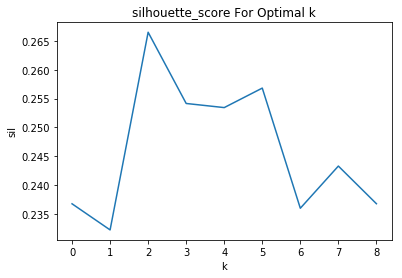

the optimal k is 2


In [64]:

#Silhouette score

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

ba_grouped_clustering = ba_competitors.drop('Neighborhood', 1)
sil = []
kmax = 10

# minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k, random_state=5).fit(ba_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(ba_grouped_clustering, labels, metric = 'euclidean'))

plt.plot(sil)
plt.xlabel('k')
plt.ylabel('sil')
plt.title('silhouette_score For Optimal k')
plt.show()
print('the optimal k is', sil.index(max(sil)))

In [65]:

# set number of clusters
kclusters = 2

ba_grouped_clustering = ba_competitors.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ba_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 1], dtype=int32)

Merging the clusters to the Buenos Aires dataframe

In [69]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ba_merged = df_ba

ba_merged = ba_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ba_merged.head()

,Neighborhood,Population Density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agronomía,8.645,-34.59243,-58.49659,1.0,BBQ Joint,Restaurant,Burger Joint
1,Almagro,33.960,-34.60324,-58.42043,0.0,BBQ Joint,Fast Food Restaurant,Beer Bar
2,Balvanera,34.950,-34.61011,-58.40602,0.0,Sandwich Place,BBQ Joint,Restaurant
3,Barracas,10.194,-34.64990,-58.38910,0.0,BBQ Joint,Restaurant,Sandwich Place
4,Belgrano,20.433,-34.56153,-58.45702,1.0,BBQ Joint,Sandwich Place,Burger Joint


I'll drop any Neighborhoods with no Venues

In [71]:
ba_merged = ba_merged.dropna(axis=0)
ba_merged = ba_merged.reset_index(drop=True)
ba_merged.head()

,Neighborhood,Population Density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agronomía,8.645,-34.59243,-58.49659,1.0,BBQ Joint,Restaurant,Burger Joint
1,Almagro,33.960,-34.60324,-58.42043,0.0,BBQ Joint,Fast Food Restaurant,Beer Bar
2,Balvanera,34.950,-34.61011,-58.40602,0.0,Sandwich Place,BBQ Joint,Restaurant
3,Barracas,10.194,-34.64990,-58.38910,0.0,BBQ Joint,Restaurant,Sandwich Place
4,Belgrano,20.433,-34.56153,-58.45702,1.0,BBQ Joint,Sandwich Place,Burger Joint


Maping the Clusters

In [72]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ba_merged['Latitude'], ba_merged['Longitude'], ba_merged['Neighborhood'], ba_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [76]:
ba_merged.loc[ba_merged['Cluster Labels'] == 0, ba_merged.columns[[0] + list(range(5, ba_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,Almagro,BBQ Joint,Fast Food Restaurant,Beer Bar
2,Balvanera,Sandwich Place,BBQ Joint,Restaurant
3,Barracas,BBQ Joint,Restaurant,Sandwich Place
10,Constitución,Sandwich Place,BBQ Joint,Restaurant
11,Flores,Restaurant,BBQ Joint,Sandwich Place
13,La Boca,BBQ Joint,Restaurant,Sandwich Place
15,Liniers,Fast Food Restaurant,Sandwich Place,Burger Joint
18,Monte Castro,Sandwich Place,Fast Food Restaurant,BBQ Joint
19,Nueva Pompeya,BBQ Joint,Fast Food Restaurant,Restaurant
22,Parque Avellaneda,Restaurant,BBQ Joint,Sandwich Place


In [77]:
ba_merged.loc[ba_merged['Cluster Labels'] == 1, ba_merged.columns[[0] + list(range(5, ba_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agronomía,BBQ Joint,Restaurant,Burger Joint
4,Belgrano,BBQ Joint,Sandwich Place,Burger Joint
5,Boedo,Burger Joint,BBQ Joint,Restaurant
6,Caballito,Restaurant,BBQ Joint,Burger Joint
7,Chacarita,Restaurant,Beer Bar,Sandwich Place
8,Coghlan,BBQ Joint,Burger Joint,Restaurant
9,Colegiales,Restaurant,BBQ Joint,Sandwich Place
12,Floresta,BBQ Joint,Restaurant,Sandwich Place
14,La Paternal,BBQ Joint,Restaurant,Burger Joint
16,Mataderos,BBQ Joint,Restaurant,Sandwich Place


# Conclusion

There are just two clusters, a possible reason for this is the covid-19 pandemic wich may have caused some venues to shut down (the case study was made on may 2020)

Cluster 1 has a more varied mix of joints.
Cluster 2 is also varied but with more BBQ joints over any other type of joint.

If a decison had to be made right now I would go with cluster 1, but because of the pandemic I would wait until the cuarentine is over and do a new analysis.